# Credit Card Fraud

In this activity, you will practice resampling techniques and use different models to classify credit card transactions as fraud or not fraud. 

The dataset includes transactions that were discovered as fraudulent (Class = 1) as well as non-fraudulent (Class = 0). The variables are PCA-decomposed and anonymized to protect customers' identities, except for the Amount variable. 

In [2]:
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
data = Path('../Resources/cc_fraud.csv')
df = pd.read_csv(data)

In [4]:
x_cols = [i for i in df.columns if i not in ('Class','Unnamed: 0')]
X = df[x_cols]
y = df['Class']

In [5]:
# Normal train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Oversample

In [6]:
# Oversample the data
from imblearn.over_sampling import SMOTE
from collections import Counter

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 7516, 1: 7516})

In [7]:
# Fit a logistic regression model to the oversampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1, max_iter=2000)
model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=2000, random_state=1)

In [8]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.90      0.99      0.94      0.90      2484
          1       0.82      0.90      0.99      0.86      0.94      0.88       139

avg / total       0.99      0.98      0.90      0.98      0.94      0.90      2623



## Undersample

In [9]:
# Undersample the Data
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 353, 1: 353})

In [10]:
# Fit a logistic regression model to the undersampled data
model = LogisticRegression(solver='lbfgs', random_state=1, max_iter=2000)
model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=2000, random_state=1)

In [11]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.92      0.96      0.93      0.86      2484
          1       0.45      0.92      0.94      0.60      0.93      0.86       139

avg / total       0.97      0.94      0.92      0.95      0.93      0.86      2623



## Combination Sampling

In [12]:
# Perform combination sampling
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 7292, 1: 7462})

In [13]:
# Fit a logistic regression model to the combination sampled data
model = LogisticRegression(solver='lbfgs', random_state=1, max_iter=2000)
model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=2000, random_state=1)

In [14]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.91      0.99      0.95      0.90      2484
          1       0.82      0.91      0.99      0.86      0.95      0.89       139

avg / total       0.99      0.98      0.91      0.98      0.95      0.90      2623



## Ensemble: Balanced Random Forest

In [15]:
# Fit a Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=1)

In [16]:
# Print the imbalanced classification report
y_pred_rf = brf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.91      0.99      0.95      0.91      2484
          1       0.78      0.91      0.99      0.84      0.95      0.89       139

avg / total       0.98      0.98      0.92      0.98      0.95      0.91      2623



## PR Curve: SMOTEENN + Logistic Regression vs. Balanced Random Forest

In [17]:
# Plot the Precision Recall Curvey for both the SMOTEENN + Logistic Regression model
# and the Balanced Random Forest model
from sklearn.metrics import precision_recall_curve

probs_lr = model.predict_proba(X_test)[:, 1]
probs_rf = brf.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf, pos_label=1)

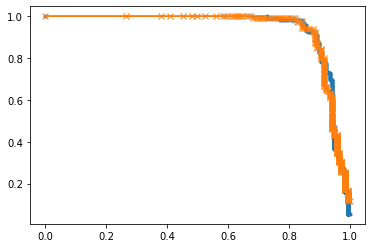

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(recall_lr, precision_lr, marker='.')
plt.plot(recall_rf, precision_rf, marker='x')

In [19]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, probs_lr)

0.942180885464476

In [20]:
average_precision_score(y_test, probs_rf)

0.9397975854182928